In [95]:
import os
from pathlib import Path


os.chdir(Path.cwd().parent)

In [96]:
import matplotlib.pyplot as plt
import numpy as np
import sys

from src.optimizers.gradient_descent import GradientDescent
from src.optimizers.step_controllers.step_controllers import (
    ConstantController, BacktrackingLineSearchController
)
from src.optimizers.utils.report import basic_report
from src.rayleight_quotient import rayleight_quotient
from src.utils.linalg import (
    tenvec, generate_normalized_vector, generate_supersymmetric_tensor
)

In [97]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [98]:
def test_rayleight_quotient_gradient_descent_base(
    A: np.ndarray,
    X: np.ndarray,
    plot: bool = False,
    verbose: bool = False) -> None:
    """
    Ensures gradient descent for f(x) = R_A(X) works properly.

    :param A: supersymmetric tensor of shape (n x n x ... x n) of order k
    :param X: normalized vector of shape (n,)
    :param plot: whether to plot f_history and f_grad_norm_history
    :param verbose: whether to print more info
    """
    if verbose:
        print(f"testing Raylight quotient gradient descent with parameters:\n"
              f"tensor a of shape {A.shape}\na = {A}\n"
              f"vector x = {X}")
    k = A.ndim
    descent = GradientDescent.from_tensor(A)
    step_controllers = [ConstantController(), BacktrackingLineSearchController()]
    if plot:
        fig, axs = plt.subplots(2, 2, figsize=(12, 8))
        fig.suptitle(f"Gradient descent for tensor of shape {A.shape}", fontsize=18)
        fig.subplots_adjust(top=0.9)

        axs[0, 0].set(title="Rayleight quotient values log scaled")
        axs[0, 1].set(title="Rayleight quotient residual values log scaled")
        axs[1, 0].set(title="Rayleight quotient gradient norm values log scaled")
        axs[1, 1].set(title="Rayleight quotient gradient residual norm values log scaled")

    success_all = True
    for step_controller in step_controllers:
        name = step_controller.name()

        X_eign = descent.minimize(X, step_controller=step_controller)
        rq_eign = rayleight_quotient(A, X_eign)

        X_expected = rq_eign * X_eign
        X_computed = tenvec(A, X_eign, times=k-1)

        success = np.allclose(X_expected, X_computed, atol=1e-4)

        if success:
            if plot:
                f_hist, f_residual_hist, f_grad_norm_hist, f_grad_residual_norm_hist = basic_report(descent._f, descent._f_grad, descent._x_history)
                for i, stat in enumerate([f_hist, f_residual_hist, f_grad_norm_hist, f_grad_residual_norm_hist]):
                    idx = np.unravel_index(i, (2, 2))
                    axs[idx].semilogy(range(len(stat)), stat, label=name)
                    axs[idx].grid(True)
                    axs[idx].legend()

                fig.tight_layout()

        else:
            print(f"gradient descent with {name} step controller failed", file=sys.stderr)
            success_all = False
    assert success_all


In [99]:
def test_rayleight_quotient_gradient_descent_dummy() -> None:
    n = 4
    k = 4
    a = np.zeros(np.full(shape=k, fill_value=n))
    for i in range(n):
        a[tuple(np.full(shape=k, fill_value=i))] = 2 * i + 1
    x = generate_normalized_vector(n)
    test_rayleight_quotient_gradient_descent_base(a, x)

def test_rayleight_quotient_gradient_descent_simple() -> None:
    n = 2
    k = 2
    a = generate_supersymmetric_tensor(n, k)
    x = generate_normalized_vector(n)
    test_rayleight_quotient_gradient_descent_base(a, x, plot=True)

def test_rayleight_quotient_gradient_descent_medium() -> None:
    n = 3
    k = 3
    a = generate_supersymmetric_tensor(n, k)
    x = generate_normalized_vector(n)
    test_rayleight_quotient_gradient_descent_base(a, x, plot=True)

def test_rayleight_quotient_gradient_descent_hard() -> None:
    n = 6
    k = 6
    a = generate_supersymmetric_tensor(n, k)
    x = generate_normalized_vector(n)
    test_rayleight_quotient_gradient_descent_base(a, x, plot=True)

In [100]:
test_rayleight_quotient_gradient_descent_dummy()

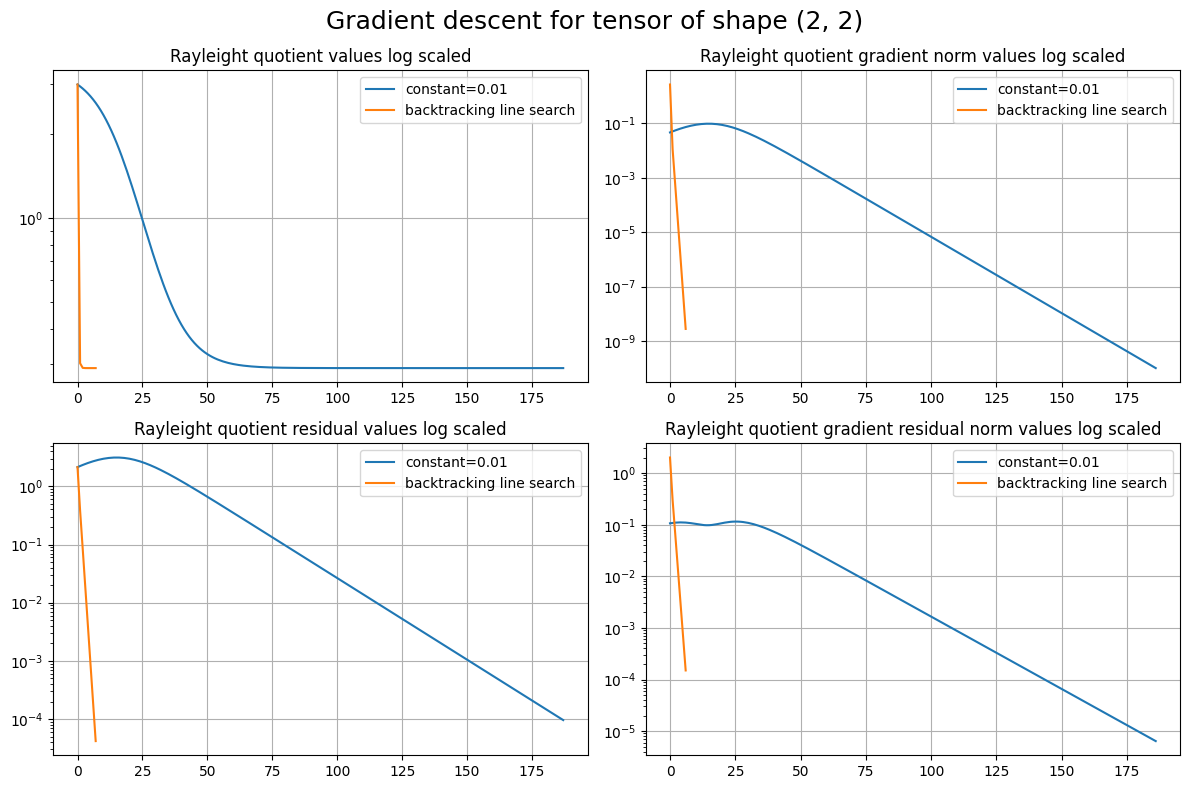

In [101]:
test_rayleight_quotient_gradient_descent_simple()

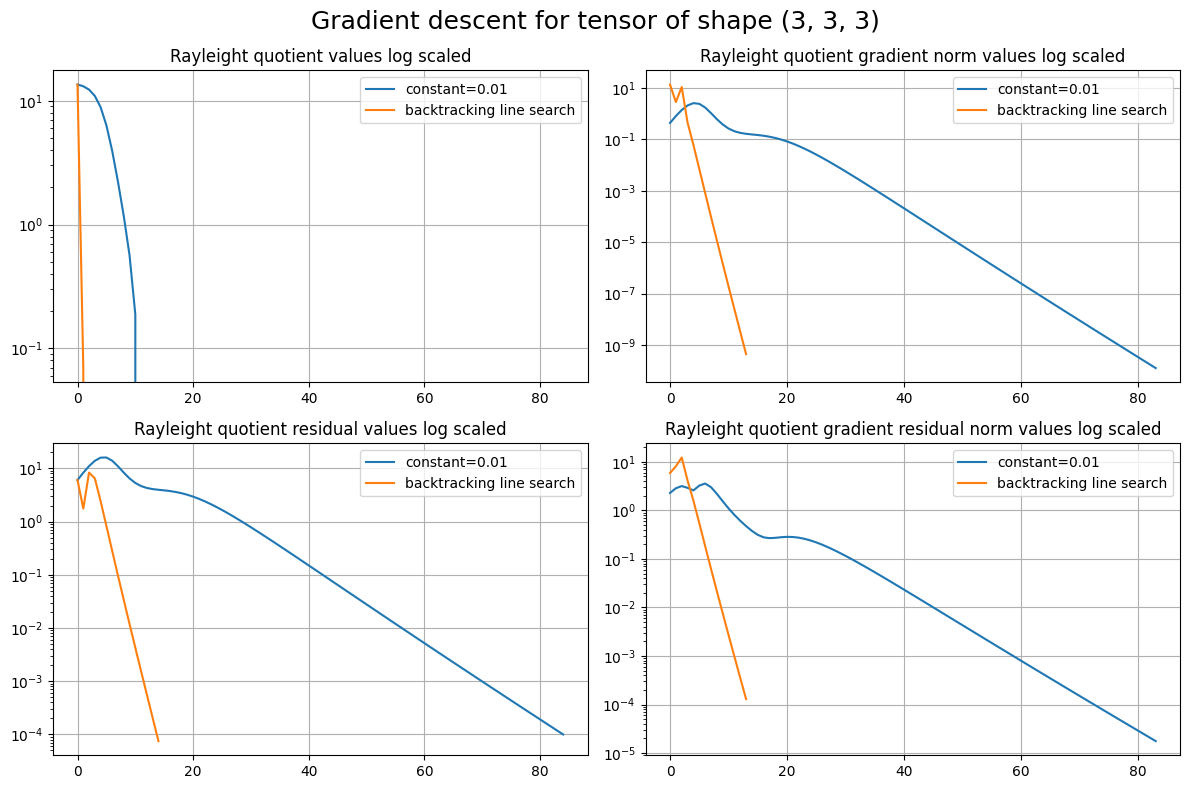

In [102]:
test_rayleight_quotient_gradient_descent_medium()

gradient descent with constant=0.01 step controller failed


AssertionError: 

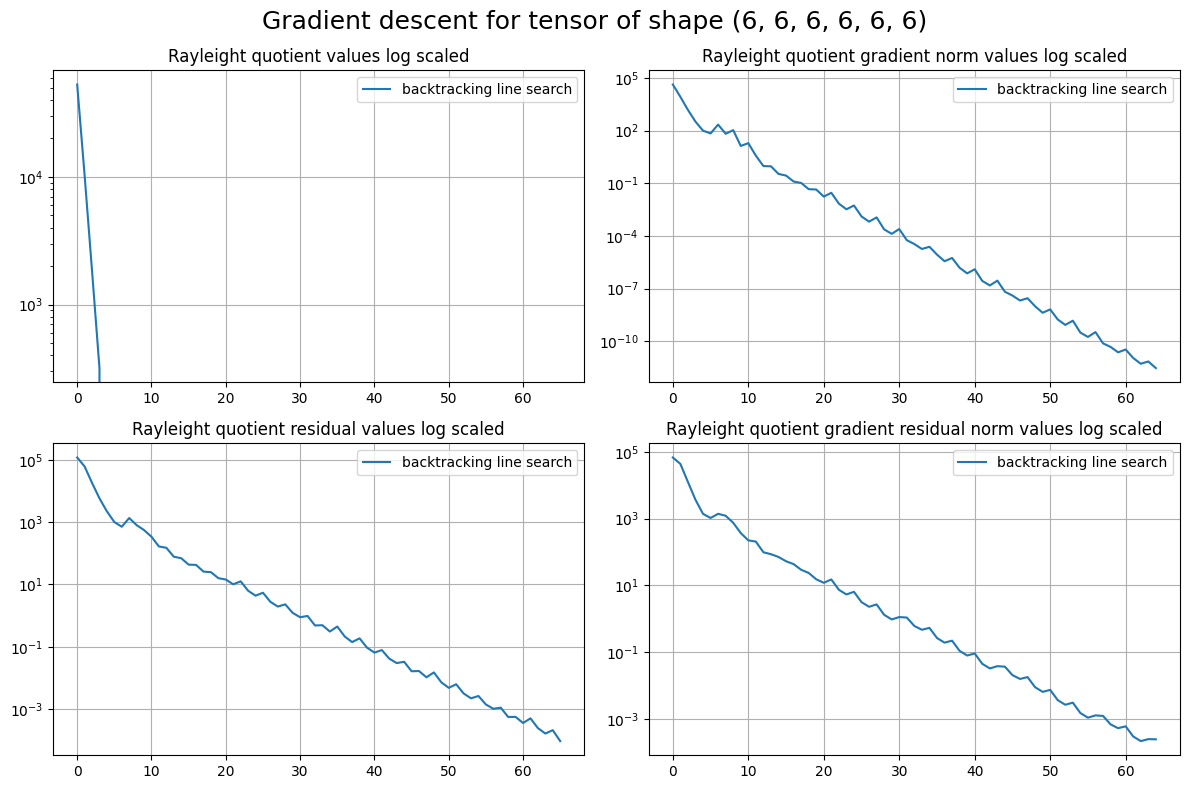

In [103]:
test_rayleight_quotient_gradient_descent_hard()